## NB Goal:
This Notebook plan to discover and explore trends and relationship behind the SF Employee Compensation datasets, in order to prepare a data cleaning function for further visualization.

## Steps:
* Section 1: Load and Glance
* Section 2: EDA
* Section 3: Data Challenges
    * Duplicate employee investigation
    * Negative and zero Numerical Value 
    * Numerical variables Perfect multicollinearity investigation


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


from sodapy import Socrata
from config import API_Token

plt.style.use('fivethirtyeight')

%matplotlib inline

## Section 1: Load and Glance

### Assumptions and scope:
The origin datasets contains over 750K records from 2014 to 2022, Since the project goal is ultimately building an interactive dashborad app, I decide to query a part of dataset by filtering calendar year only and within past 5 years from 2018 to 2022. 
### Steps:
1. Load data through API with preliminary filter query
2. Discover dataframe general information
3. Columns data types transform and clean

### Insights:
Currently, the dataset we used has 168437 rows and 22 columns. Ater cleaning, we have 10 numerical features like salaries and total_compensation column. 

In [2]:
# API Call
socrata_domain = 'data.sfgov.org,'
socrata_dataset_identifier = '88g8-5mnd'
client = Socrata("data.sfgov.org",API_Token)
# add filter
results = client.get_all(socrata_dataset_identifier, 
    where = "year in ('2018','2019','2020','2021','2022') and year_type = 'Calendar'" )

df_origin = pd.DataFrame(results)
# alternative#1 csv file
# df_origin = pd.read_csv('data/Employee_Compensation.csv')
# alternative#2 json file
# df_origin = pd.read_json('https://data.sfgov.org/resource/88g8-5mnd.json')

df_origin.shape  # (168437, 22)

(168437, 22)

In [3]:
# make a copy to avoid editing origin data
df = df_origin.copy()
df.head(5)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168437 entries, 0 to 168436
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   organization_group_code  168437 non-null  object
 1   job_family_code          168437 non-null  object
 2   job_code                 168437 non-null  object
 3   year_type                168437 non-null  object
 4   year                     168437 non-null  object
 5   organization_group       168437 non-null  object
 6   department_code          168437 non-null  object
 7   department               168437 non-null  object
 8   union_code               168437 non-null  object
 9   union                    168437 non-null  object
 10  job_family               168437 non-null  object
 11  job                      168437 non-null  object
 12  employee_identifier      168437 non-null  object
 13  salaries                 168437 non-null  object
 14  overtime            

### 3. Columns Transform and clean

### Asumption: 
* Transform the year and salaries-related(money_related) columns into numerical, and keep information columns such as employee_id, group code, familiy code as categorical features.

* Irrelevant columns: Union related columns are out of our current scope. 

In [4]:
# clean up column names, save into a list, check the data type
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
column_name = df.columns.tolist()
print(column_name)
print(f'We have total of {len(column_name)} columns')
print(df.dtypes)

['organization_group_code', 'job_family_code', 'job_code', 'year_type', 'year', 'organization_group', 'department_code', 'department', 'union_code', 'union', 'job_family', 'job', 'employee_identifier', 'salaries', 'overtime', 'other_salaries', 'total_salary', 'retirement', 'health_and_dental', 'other_benefits', 'total_benefits', 'total_compensation']
We have total of 22 columns
organization_group_code    object
job_family_code            object
job_code                   object
year_type                  object
year                       object
organization_group         object
department_code            object
department                 object
union_code                 object
union                      object
job_family                 object
job                        object
employee_identifier        object
salaries                   object
overtime                   object
other_salaries             object
total_salary               object
retirement                 object
health_

In [5]:
# define the numerical column
numerical_column_names = [ 'year', 'salaries', 'overtime', 'other_salaries', 'total_salary', 'retirement', 'health_and_dental', 'other_benefits', 'total_benefits', 'total_compensation']

# change data types
for column in column_name:
    if column in numerical_column_names:
        if column == 'year':
            df[column] = df[column].astype('int')
        else:
            df[column] = df[column].astype('float64')
print(df.dtypes)

organization_group_code     object
job_family_code             object
job_code                    object
year_type                   object
year                         int64
organization_group          object
department_code             object
department                  object
union_code                  object
union                       object
job_family                  object
job                         object
employee_identifier         object
salaries                   float64
overtime                   float64
other_salaries             float64
total_salary               float64
retirement                 float64
health_and_dental          float64
other_benefits             float64
total_benefits             float64
total_compensation         float64
dtype: object


# Section 2: EDA
1. Summary Statistics
2. missing value

## Insights:
There is no missing data in all columns.
the year range is within range, 2022 data shifts 50% median value to 2019, instead of 2020

salaries are righ-skewed(mean > median), since large value/outlier pull mean towards right.

6 unique organization group, 51 department, 56 job family, 1111 job_code, 66 or 69 union 

irrelavant columns such as code information, union information


## Further investigation:
1. Negative in salaries to make high level total_salary as 0, will try to take a closely look at these 0 rows
2. Zero value in money-related columns('total_compensation)
3. Duplicate Employee_iderntifer
2. Outliers

In [6]:
df.describe()

,year,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
count,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000,168437.000000
mean,2019.465628,82429.954530,7078.091892,3910.599044,93418.645465,17197.856361,11901.419924,5816.690627,34915.966912,128334.612378
std,1.110878,51999.156269,16048.602443,7786.099876,60913.718752,12232.590140,6681.298768,3702.460204,20464.999950,79653.803756
min,2018.000000,-9942.330000,-22453.280000,-480.000000,0.000000,-37.890000,-745.720000,0.000000,0.000000,0.000000
25%,2018.000000,47643.000000,0.000000,0.000000,52245.360000,8876.520000,7718.990000,2528.620000,20528.870000,74311.860000
50%,2019.000000,80493.500000,62.070000,862.500000,89841.010000,16923.670000,14950.300000,5923.960000,38512.260000,128503.140000
75%,2020.000000,115906.160000,6562.110000,4581.330000,130409.340000,24197.040000,16303.470000,8699.000000,47968.360000,179060.980000
max,2021.000000,596615.860000,315896.410000,326959.390000,596615.860000,150142.960000,59405.230000,18779.490000,175232.200000,762684.040000


In [7]:
df.describe(include='object')


,organization_group_code,job_family_code,job_code,year_type,organization_group,department_code,department,union_code,union,job_family,job,employee_identifier
count,168437,168437,168437,168437,168437,168437,168437,168437,168437,168437,168437,168437
unique,6,57,1111,1,6,51,51,69,66,56,1111,164211
top,02,2300,9163,Calendar,"Public Works, Transportation & Commerce",DPH,Public Health,790,"SEIU, Local 1021, Misc",Nursing,Transit Operator,0
freq,53192,18130,10986,168437,53192,38362,38362,46720,63754,18130,10986,6


In [8]:
# drop inrrelevant features 
relevant_cat_column_name = [ 'organization_group', 'department', 'job_family',  'job', 'employee_identifier']
irrelavant_column_name = ['organization_group_code', 'job_family_code', 'job_code', 'year_type', 'department_code',  'union_code', 'union']
df = df.drop(irrelavant_column_name, axis=1)
df.head() #(168437, 15)

,year,organization_group,department,job_family,job,employee_identifier,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
0,2018,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,38405932,81096.04,0.0,0.0,81096.04,15556.78,14433.94,6076.79,36067.51,117163.55
1,2018,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,37915952,115053.11,0.0,0.0,115053.11,22071.21,14433.94,9059.88,45565.03,160618.14
2,2018,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,37905927,107355.32,0.0,0.0,107355.32,20594.40,14433.94,8171.53,43199.87,150555.19
3,2018,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,37477463,154758.00,0.0,0.0,154758.00,28939.26,14433.94,10980.30,54353.50,209111.50
4,2018,Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,37483360,91988.81,0.0,0.0,91988.81,17647.11,14433.94,7214.21,39295.26,131284.07


In [9]:
df.shape

(168437, 15)

In [10]:
# no missing data
miss_percent = df.isnull().sum()/ df.shape[0] * 100
miss_percent

year                   0.0
organization_group     0.0
department             0.0
job_family             0.0
job                    0.0
employee_identifier    0.0
salaries               0.0
overtime               0.0
other_salaries         0.0
total_salary           0.0
retirement             0.0
health_and_dental      0.0
other_benefits         0.0
total_benefits         0.0
total_compensation     0.0
dtype: float64

## Section 3: data challenges
1. Duplicate employee investigation
2. Negative Numerical Value 
2. Numerical features relationship


### Duplicate employee investigation
#### Insights:
1. check if meaningless records in employee_id ===> total of 6 records have '0' in employee_id
2. 4226 duplicate employees_id
3. 3990 employee_ID has multiple job

#### Action
Drop the dulitcate, since 4226 of 168437 total employees can be neglected, so all rows will be omitted.

In [11]:
# There are 4226 example has duplicate employeeIid, 
df[df.employee_identifier.duplicated()].shape # (4226, 15)

#check zero record
zero_employee_cnt = len(df[df.employee_identifier =='0'])
print(f'{zero_employee_cnt} employee_ID are 0')

6 employee_ID are 0


In [13]:
# how many employee has more than one job, 3990
multiple_job_employee = df.groupby('employee_identifier')['job'].count()
print(len(multiple_job_employee[multiple_job_employee!=1]),'employee_ID has multiple job')

3990 employee_ID has multiple job


In [14]:
df.employee_identifier.nunique()

164211

In [15]:
df.employee_identifier.duplicated().sum()

4226

#### Action

In [16]:
df = df.drop_duplicates(subset=['employee_identifier'], keep='last',ignore_index=True)

df.shape

(164211, 15)

In [17]:
df.sample(3)

,year,organization_group,department,job_family,job,employee_identifier,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
84964,2020,Public Protection,Fire Department,Fire Services,Firefighter,40771275,125632.88,2097.88,23601.43,151332.19,31172.62,18632.45,2520.63,52325.70,203657.89
144902,2021,Human Welfare & Neighborhood Development,Homeless Services,Human Services,Program Support Analyst,47756538,108491.35,0.00,1650.00,110141.35,23616.03,16398.07,8819.39,48833.49,158974.84
70164,2019,Community Health,Public Health,Human Services,Sen Hospital Eligibility Wrkr,40789467,74359.27,360.19,2074.39,76793.85,15178.42,13499.06,6303.39,34980.87,111774.72


###  Negative and zero Numerical Value 

Assumption: the negative individual salary, bous is willing to make zero totl_salary and total_compensation.

#### Insights
Only 5 money columns have nagative value and it distributes in following columns:
salaries(2), overtime(6),other_salaries(2),retirement(2), health_and_dental(1),
I filtered origin DF to get a nagetive DF with a nagetive value exsit in any column, result in only 20 rows.
with avg total_salary = 64921, avg total_benefits = 27701, avg total_compensation = 92622
with max total_compensation range in (60 ,330061)
After negative remove, we have 164191 rows. 

Next step is deal with zero value in 3 total_* columns. 
Then after zero value drop, we have 163922 rows.
#### Actions:
1. Drop records with any-nagative value, since it's only 20 examples and total_compensation's mean is 92622, which within the range.
2. Drop off zero value recods in total_salary, total_benefits and total_compensation columns.
3. Verify if dropped out all zero values in 3 total_* columns

In [18]:
money_df = df[['salaries', 'overtime', 'other_salaries', 'total_salary', 'retirement', 'health_and_dental', 'other_benefits', 'total_benefits', 'total_compensation']]
money_df.describe()

,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
count,164211.000000,164211.000000,164211.000000,164211.000000,164211.000000,164211.000000,164211.000000,164211.000000,164211.000000
mean,82214.169397,6870.114720,3786.529446,92870.813563,17176.275021,11904.259787,5884.183961,34964.718769,127835.532332
std,51695.131810,15776.957461,7671.780466,60198.902923,12213.801316,6660.669390,3702.506958,20448.876316,78969.842700
min,-322.600000,-22453.280000,-480.000000,0.000000,-37.890000,-745.720000,0.000000,0.000000,0.000000
25%,48254.960000,0.000000,0.000000,52795.700000,9044.255000,7792.165000,2565.980000,20827.525000,75211.470000
50%,80290.280000,48.660000,809.230000,89537.940000,16875.080000,14950.300000,6014.300000,38452.920000,128076.650000
75%,114694.010000,6309.665000,4408.670000,128978.530000,23939.330000,16271.940000,8765.125000,47932.480000,177456.260000
max,596615.860000,315896.410000,326959.390000,596615.860000,150142.960000,48687.290000,18779.490000,175232.200000,762684.040000


In [19]:
# how many nagative values in each column
len(money_df[money_df['salaries']<0])


2

In [20]:
# filter all negative value
negative_money_df = money_df[(money_df['salaries']<0)|(money_df['overtime']<0)|(
    money_df['other_salaries']<0|(money_df['retirement']<0)|
    (money_df['health_and_dental']<0))]

negative_money_df.shape #(20, 9)

negative_money_df

,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
29133,70009.70,0.00,-246.64,69763.06,13383.30,14543.01,5708.22,33634.53,103397.59
44308,-322.60,601.77,-15.30,263.87,82.68,0.00,4.47,87.15,351.02
66526,94863.80,0.00,-455.89,94407.91,18842.32,14946.71,7044.83,40833.86,135241.77
78679,15185.48,-14.91,349.53,15520.10,0.00,0.00,1204.61,1204.61,16724.71
79028,22883.66,-45.56,29.16,22867.26,5303.39,0.00,1774.87,7078.26,29945.52
86908,93545.46,0.00,-25.51,93519.95,35685.10,7636.51,559.43,43881.04,137400.99
89272,22966.87,0.00,-0.01,22966.86,0.00,0.00,1782.59,1782.59,24749.45
115725,7898.70,2913.89,-71.29,10741.30,1552.61,0.00,833.70,2386.31,13127.61
120912,59039.50,-218.33,606.46,59427.63,14801.87,15337.58,4639.13,34778.58,94206.21
128531,0.00,129.60,0.00,129.60,-6.22,0.00,9.92,3.70,133.30


In [21]:
negative_money_df.describe()

,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
count,20.000000,20.00000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,63776.872500,1035.63750,108.505000,64921.0150,13795.035500,9410.872000,4495.469500,27701.377000,92622.392000
std,62616.308341,6970.15739,494.348781,59990.1820,14674.666736,8258.971644,4054.010544,25404.131707,85049.706498
min,-322.600000,-22453.28000,-480.000000,56.3000,-6.220000,0.000000,4.370000,3.700000,60.670000
25%,15144.157500,-3.73500,-80.607500,18442.4825,521.490000,0.000000,1111.882500,2235.380000,22743.265000
50%,59682.520000,0.00000,-17.535000,62153.0350,14092.585000,11215.575000,3620.410000,34206.555000,97537.865000
75%,93980.847500,3299.58000,84.370000,95722.4650,20746.767500,16109.022500,7383.307500,44289.550000,139346.045000
max,261616.560000,16012.93000,1760.000000,239413.2800,55310.130000,22237.220000,13100.590000,90647.940000,330061.220000


#### Action
drop out all nagetive and zero records in $ columns

In [23]:
df = df[~df.index.isin(negative_money_df.index)]

df.shape
# (164191, 15)

(164191, 15)

In [28]:
# zero value investigation
df = df[(df['total_salary']>0)&(df['total_benefits']>0)&(df['total_compensation']>0)]
df.shape 
# (163922, 15) after remove 0 values

(163922, 15)

#### Verify

In [34]:
# verify if dropped out all zero values in 3 total_* columns
all((df['total_salary']!=0)&(df['total_benefits']!=0)&(df['total_compensation']!=0))
# True

True

### Numerical variables Perfect multicollinearity investigation

#### Assumption:
in the row-level, tere might be a equation that:
    salaries + overtime + other_salaries = total_salary
    retirement + health_and_dental + other_benefits = total_benefits	
then, 
    total_salary + total_benefits = total_compensation

#### Steps:
1. create a new DF, add new columns from addtion calculation
2. verify if the calculation is close to ground turth data
#### Insights
Our assumptions all are True:
ALL total salary addtion assumption is True
ALL total benefits addtion assumption is True
ALL total compensation addtion assumption is True

#### Actions
we are able to drop off all duplicate information (6 columns) and keep total_* level columns and saved into a new dataframe named high_level_df



In [43]:
df.head(4)

,year,organization_group,department,job_family,job,employee_identifier,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation
0,2018,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,38405932,81096.04,0.0,0.0,81096.04,15556.78,14433.94,6076.79,36067.51,117163.55
1,2018,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,37915952,115053.11,0.0,0.0,115053.11,22071.21,14433.94,9059.88,45565.03,160618.14
2,2018,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,37905927,107355.32,0.0,0.0,107355.32,20594.40,14433.94,8171.53,43199.87,150555.19
3,2018,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,37477463,154758.00,0.0,0.0,154758.00,28939.26,14433.94,10980.30,54353.50,209111.50


In [47]:
additon_df = df.copy()
additon_df.shape

(163922, 15)

In [56]:
additon_df['verify_salary'] = additon_df['salaries']+additon_df['overtime']+additon_df['other_salaries']
additon_df['verify_benefits'] = additon_df['retirement']+additon_df['health_and_dental']+additon_df['other_benefits']
additon_df['verify_total_S&B'] = additon_df['total_salary']+additon_df['total_benefits']
additon_df.shape

(163922, 18)

In [57]:
additon_df.head(3)

,year,organization_group,department,job_family,job,employee_identifier,salaries,overtime,other_salaries,total_salary,retirement,health_and_dental,other_benefits,total_benefits,total_compensation,verify_total_S&B,verify_salary,verify_benefits
0,2018,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,38405932,81096.04,0.0,0.0,81096.04,15556.78,14433.94,6076.79,36067.51,117163.55,117163.55,81096.04,36067.51
1,2018,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,37915952,115053.11,0.0,0.0,115053.11,22071.21,14433.94,9059.88,45565.03,160618.14,160618.14,115053.11,45565.03
2,2018,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,37905927,107355.32,0.0,0.0,107355.32,20594.40,14433.94,8171.53,43199.87,150555.19,150555.19,107355.32,43199.87


In [58]:
# verify 3 totl_* level comlumns
print('ALL total salary addtion assumption is', all(np.isclose(additon_df['verify_salary'], additon_df['total_salary'])))
print('ALL total benefits addtion assumption is', all(np.isclose(additon_df['verify_benefits'], additon_df['total_benefits'])))
print('ALL total compensation addtion assumption is', all(np.isclose(additon_df['verify_total_S&B'], additon_df['total_compensation'])))


ALL total salary addtion assumption is True
ALL total benefits addtion assumption is True
ALL total compensation addtion assumption is True


#### Action:

In [59]:
df.shape

(163922, 15)

In [60]:
high_level_df = df.drop(['salaries', 'overtime', 'other_salaries',
    'retirement','health_and_dental', 'other_benefits'], axis =1)
high_level_df.shape

(163922, 9)

#### correlation

In [ ]:
# corr
corrMatrix = df.corr()

sns.heatmap(corrMatrix, annot = True, cmap= 'coolwarm')

# outlier 

In [189]:
outlier_df = df.copy()
outlier_df.shape

(163004, 18)

#### the 3 total $ distribution before remove outliers

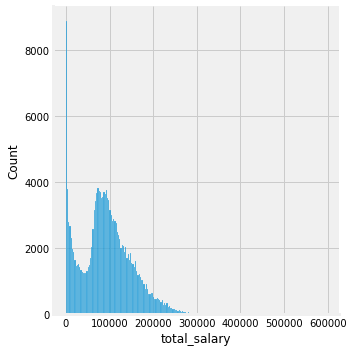

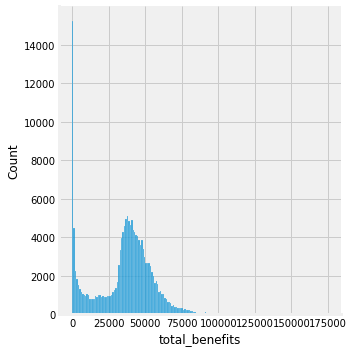

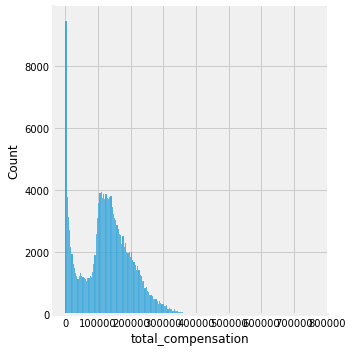

In [186]:
num_cols = ['total_salary','total_benefits', 'total_compensation']
for col in num_cols:
    sns.displot(x = col, data=outlier_df)
    plt.show()

In [187]:
# total compensation first

outlier_df['ts_zscore'] = np.abs(stats.zscore(df['total_salary']))
outlier_df['tb_zscore'] = np.abs(stats.zscore(df['total_benefits']))
outlier_df['tc_zscore'] = np.abs(stats.zscore(df['total_compensation']))

print("Total_Salary outlier:",  outlier_df[outlier_df['ts_zscore']> 3].shape[0])
print("Total_benefits outlier:",  outlier_df[outlier_df['tb_zscore']> 3].shape[0])
print("Total_compensation outlier:",  outlier_df[outlier_df['tc_zscore']> 3].shape[0])

# Total_Salary outlier: 948
# Total_benefits outlier: 445
# Total_compensation outlier: 707

Total_Salary outlier: 948
Total_benefits outlier: 445
Total_compensation outlier: 707


### action
drop outliers

In [197]:
df = outlier_df[(outlier_df['ts_zscore']< 3)&(outlier_df['tb_zscore']< 3)&(outlier_df['tc_zscore']< 3)]
df.drop(['ts_zscore','tb_zscore','tc_zscore'], axis=1, inplace=True)
df.shape
# (163004, 15)

(163004, 15)

In [198]:
# only care total_salary and total_benefits outliers
def outlier_remove(df):
    df['ts_zscore'] = np.abs(stats.zscore(df['total_salary']))
    df['tb_zscore'] = np.abs(stats.zscore(df['total_salary']))

    df[(df['ts_zscore']< 3)&(outlier_df['tb_zscore']< 3)]
    return df.drop(['ts_zscore','tb_zscore'], axis=1, inplace=True)

#### the 3 total $ distribution after remove outliers

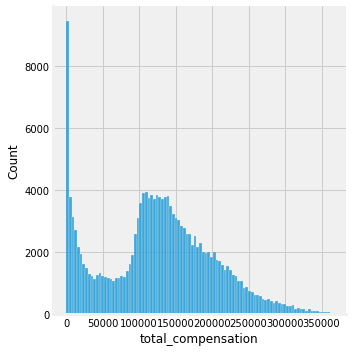

In [182]:
num_cols = ['total_salary','total_benefits', 'total_compensation']
for col in num_cols:
    sns.displot(x = col, data=outlier_df)
    plt.show()

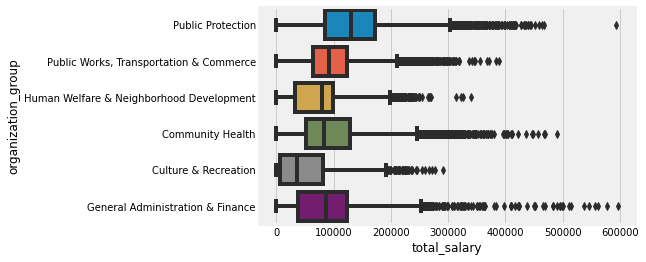

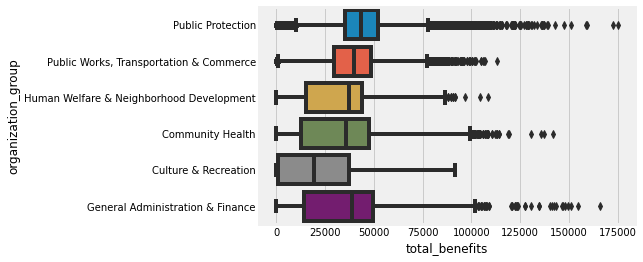

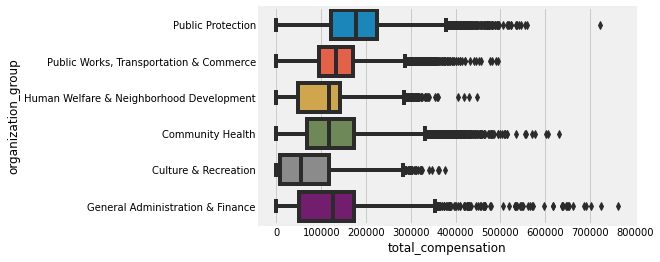

In [176]:

num_cols = ['total_salary','total_benefits', 'total_compensation']
for col in num_cols:
    sns.boxplot(y = outlier_df['organization_group'], x = col, data=outlier_df)
    plt.show()

Explore categorical variables 
1. organization_group: 6 different group, The "Public Works, Transportation & Commerce" org group with 53192 records, while "Human Welfare & Neighborhood Development" is the least with 14061 records


Job:
Transit Operator             10986
Special Nurse                 6423
Registered Nurse              6015


In [67]:
df.organization_group.value_counts()

Public Works, Transportation & Commerce     53192
Community Health                            38362
Public Protection                           32623
General Administration & Finance            16065
Culture & Recreation                        14134
Human Welfare & Neighborhood Development    14061
Name: organization_group, dtype: int64

In [ ]:
# 

Text(0.5, 1.0, 'Org group value counts')

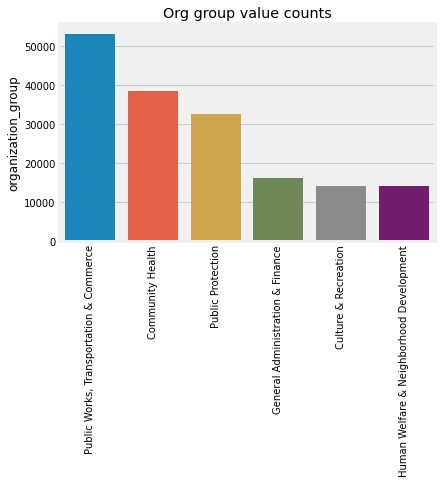

In [69]:
# org_group value counts
sns.barplot(x=df.organization_group.value_counts().index, y=df.organization_group.value_counts())
plt.xticks(rotation=90)
plt.title('Org group value counts')

In [78]:
df.department.value_counts().head(10)

Public Health                     38362
Municipal Transportation Agcy     25883
Police                            12883
Human Services                    11965
Public Utilities Commission       10064
Recreation And Park Commission     8519
Fire Department                    7731
Airport Commission                 7601
Department Of Public Works         6648
Administrative Services            4479
Name: department, dtype: int64

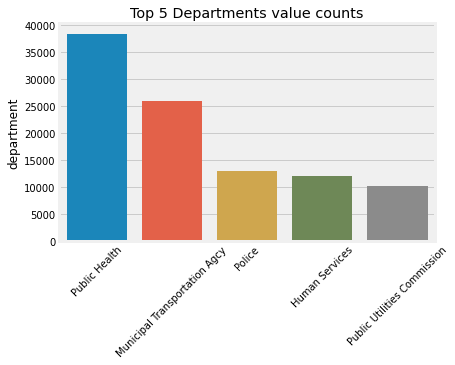

In [83]:
sns.barplot(x=df.department.value_counts()[:5].index, y=df.department.value_counts()[:5])
plt.xticks(rotation=45)
plt.title('Top 5 Departments value counts')
plt.show()

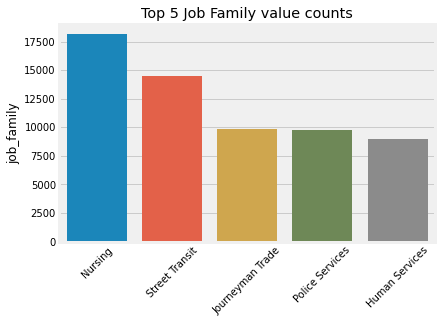

In [84]:
sns.barplot(x=df.job_family.value_counts()[:5].index, y=df.job_family.value_counts()[:5])
plt.xticks(rotation=45)
plt.title('Top 5 Job Family value counts')
plt.show()

In [86]:
df.job.value_counts().head(10)

Transit Operator             10986
Special Nurse                 6423
Registered Nurse              6015
Firefighter                   3480
Custodian                     3476
Police Officer 3              3441
Public Service Trainee        2794
Recreation Leader             2404
Patient Care Assistant        2261
HSA Sr Eligibility Worker     2177
Name: job, dtype: int64

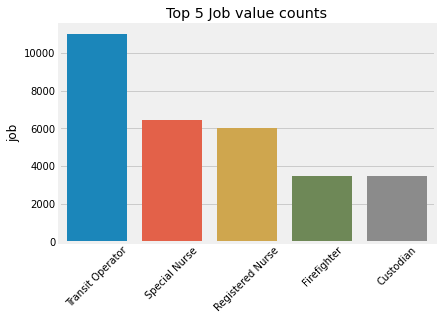

In [85]:
sns.barplot(x=df.job.value_counts()[:5].index, y=df.job.value_counts()[:5])
plt.xticks(rotation=45)
plt.title('Top 5 Job value counts')
plt.show()

Section 1 conclusion:

We have total of 22 columns


### Aggregated Table Explore

In [ ]:
df.groupby(['Organization Group'])[money_df.columns].describe()

In [6]:
test_df = df.groupby(['Year Type','Year','Job'])['Salaries','Total Compensation'].mean()
test_df.head(10)

/var/folders/30/kt35bq3n3_b90dxt80z_vjjw0000gn/T/ipykernel_41980/849934878.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_df = df.groupby(['Year Type','Year','Job'])['Salaries','Total Compensation'].mean()


Salaries  Total Compensation
Year Type Year Job                                                        
Calendar  2013 Account Clerk              40388.399216        61702.154608
               Accountant I               67838.413333        99504.836667
               Accountant II              57121.076629        83004.125506
               Accountant III             67190.154862        94839.112844
               Accountant IV              85711.871500       118490.453333
               Accountant Intern          24530.535614        36561.595965
               Acupuncturist              75411.000000       111214.280000
               Adm, SFGH Medical Center  276831.500000       355107.360000
               Admin Analyst 3            68009.620000        96174.406667
               Administrative Analyst     62668.591644        89979.665274

In [8]:
test_df = df.groupby(['Year Type','Year'])[['Salaries','Total Compensation']].mean()
test_df.head(10)

Salaries  Total Compensation
Year Type Year                                  
Calendar  2013  64717.640360        99638.412577
          2014  62261.763051        97717.615926
          2015  63801.845319        98605.356720
          2016  66498.335433       102014.919491
          2017  74770.937352       114479.846099
          2018  76919.412119       118348.406340
          2019  77060.393590       119842.301509
          2020  86018.214281       134258.764395
          2021  90601.774692       142360.177374
Fiscal    2013  62875.983167        96087.879968

In [ ]:
groupped_by_department = corrected_df.groupby(by='Department')
departments_stats = groupped_by_department['Salaries'].agg(['mean', 'sum', 'count', 'std'])
departments_stats['sum'] = departments_stats['sum'] / 1000000000.0

top_departments_by_department_budget = departments_stats.sort_values(by='sum', ascending=False).iloc[0:10]
top_departments_by_average_salary = departments_stats.sort_values(by='mean', ascending=False).iloc[0:10]